### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

Download plugin model

In [3]:
# pip install ewatercycle-HBV==1.3.0

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [5]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
stor_names = ["Si", "Su", "Sf", "Ss"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [6]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1999-12-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [7]:
from ewatercycle_HBV.forcing import HBVForcing

In [8]:
# to do: get alpha correctly

In [9]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          forcing_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha
                          )

In [10]:
ds = test_forcing.from_camels_txt()

In [11]:
ds

<xarray.Dataset>
Dimensions:  (time: 851)
Coordinates:
  * time     (time) datetime64[ns] 1997-08-02 1997-08-03 ... 1999-11-30
Data variables:
    dayl     (time) float64 5.011e+04 5.011e+04 ... 3.421e+04 3.421e+04
    pr       (time) float64 0.0 0.0 0.0 14.22 0.0 ... 18.02 13.18 0.0 0.0 0.0
    srad     (time) float64 500.2 416.9 388.0 325.0 ... 189.7 215.1 224.5 204.3
    swe      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    tasmax   (time) float64 26.28 25.71 26.95 25.26 ... 13.89 10.8 8.92 3.61
    tasmin   (time) float64 10.82 14.14 16.32 13.2 8.2 ... -0.18 0.13 -2.21 -5.8
    vp       (time) float64 1.305e+03 1.617e+03 1.85e+03 ... 615.0 520.3 398.5
    pev      (time) float64 3.638 3.234 3.155 2.539 ... 0.5322 0.4936 0.4064
Attributes:
    title:            HBV forcing data
    history:          Created by ewatercycle_HBV.forcing.HBVForcing.from_came...
    units:            daylight(s), precipitation(mm/day), mean radiation(W/m2...
    lat:              38.31
    elevation(m):     911.0
    area basin(m^2):  44787641.0

#### import observations

In [12]:
observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'

In [13]:
cubic_ft_to_cubic_m = 0.0283168466 

In [14]:
new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
new_header_dict = dict(list(zip(range(len(new_header)),new_header)))

df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
df_Q = df_Q.rename(columns=new_header_dict)
df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
df_Q.index.name = "time"
df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
df_Q = df_Q.dropna(axis=0)

<Axes: xlabel='time'>

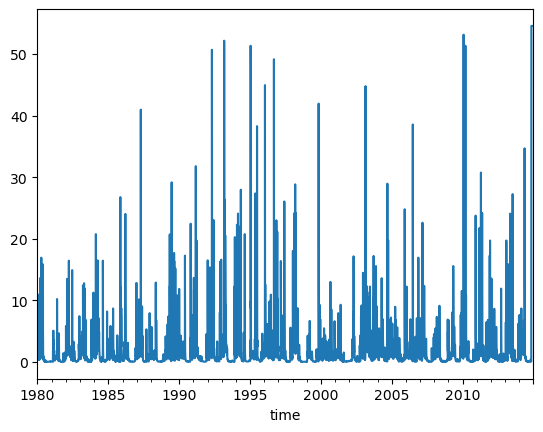

In [15]:
df_Q['Q'].plot()
# ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-06-01')))

#### import model

In [16]:
from ewatercycle.models import HBV

# run DA

In [17]:
import random
rng = np.random.default_rng() # Initiate a Random Number Generator

In [18]:
def setup_ensemble(n_particles):
    # for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
    array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
    p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
    
    ensemble = []
    for i in range(n_particles):
        ensemble.append(HBV(forcing=test_forcing))
        
    for index, ensembleMember in enumerate(ensemble):
        config_file, _ = ensembleMember.setup(
                                              parameters=','.join([str(p) for p in p_intial[index]]), 
                                              initial_storage=','.join([str(s) for s in s_0]),
                                              alpha=alpha
                                             )
        ensembleMember.initialize(config_file)
        
    return ensemble 

def generate_weights(Q_m_at_ts, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = Q_m_at_ts # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

def add_noise(like_sigma):
    return rng.normal(loc=0, scale=like_sigma)   # log normal so can't go to 0 ? 

def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [19]:
n_particles = 100 # 50 seems max for current setup :P

###### 
#### if fails, run in cmd:
[link1](https://stackoverflow.com/questions/65272764/ports-are-not-available-listen-tcp-0-0-0-0-50070-bind-an-attempt-was-made-to)
[link2](https://asheroto.medium.com/docker-error-an-attempt-was-made-to-access-a-socket-in-a-way-forbidden-by-its-access-permissions-15a444ab217b)
```bash
net stop winnat
netsh int ipv4 set dynamic tcp start=49152 num=16384
netsh int ipv6 set dynamic tcp start=49152 num=16384
net start winnat
````

In [21]:
# # #### run if fails 
# for index, ensembleMember in enumerate(ensemble):
#     ensembleMember.finalize()

In [22]:
# create list of ensemble members
ensemble = setup_ensemble(n_particles)
ref_model = ensemble[0]

In [23]:
n_timesteps = len(ds.time.values) - 1
# n_timesteps  = 300

In [24]:
# set up arrays
n_storage_terms = len(stor_names)
n_param_terms = len(param_names)
Q_m_arr = np.zeros((n_particles, n_timesteps))
storage_terms_arr = np.zeros((n_particles, n_timesteps, n_storage_terms))
parameter_terms_arr = np.zeros((n_particles, n_timesteps, n_param_terms))
t_lag_max = 20 # for now? 
index_t_lag = 5 # fith parameter (base 0)
print(f'{index_t_lag}th index is {param_names[index_t_lag]}')
lag_vector_memory_arr = np.zeros((n_particles, n_timesteps,t_lag_max))

5th index is Tlag


In [25]:
print(param_names)
print(stor_names)

['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks']
['Si', 'Su', 'Sf', 'Ss']


In [26]:
time = []
Q_obs_t_lst = []
t_index = 0 
## running for whole timeseries takes long, just do first couple of months to see inpact
# while ref_model.time < ref_model.start_time + n_timesteps * ref_model.time_step:
while ref_model.time < ref_model.end_time:
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))

    # run model forward
    for m_index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        # get model, storage and paramers
        Q_m_arr[m_index, t_index] = ensembleMember.get_value("Q_m")[0] # 1 observation per ensemble member - TODO: would be great to just do this in one go!
        storage_terms_arr[m_index, t_index] = np.array([ensembleMember.get_value(storage) for storage in stor_names]).flatten().copy()
        parameter_terms_arr[m_index, t_index] = np.array([ensembleMember.get_value(parameter) for parameter in param_names]).flatten().copy()

        # get the memory vector
        t_lag = int(parameter_terms_arr[m_index, t_index, index_t_lag])
        lag_vector_memory_arr[m_index, t_index, :t_lag] = np.array([ensembleMember.get_value(f"memory_vector{i}") for i in range(t_lag)]).flatten()

    # if t_index % 1 == 0:
    ### resample
    Q_obs = df_Q.loc[pd.Timestamp(ref_model.time_as_datetime.date()),"Q"] # get observed value from DF 
    Q_obs_t_lst.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    # add error to Q_obs - roughly sig^2 = (0.1 * Q_obs)^2 - clark 2008
    likelihood = generate_weights(Q_m_arr[:,t_index], Q_obs) 
    resample_indices = random.choices(population=np.arange(n_particles),weights=likelihood, k=n_particles)
    
    
    new_parameters = parameter_terms_arr[:, t_index].copy()[resample_indices]
    new_storage    = storage_terms_arr[:, t_index].copy()[resample_indices]
    new_lag        = lag_vector_memory_arr[:,t_index].copy()[resample_indices] # dont have a way to set new lag function as of yet

    ## add noise
    ## TODO: literature to choose sigma - maybe make sigma dependant on the parameter: i.e. %age of parameter
    # sigma = 0.005
    sigma = 0.1* Q_obs
    new_parameters = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in par]) 
                               for par in new_parameters.T]).T
    new_storage    = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in stor]) 
                               for stor in new_storage.T]).T

    # new_lag        = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in lag]) 
    #                            for lag in new_lag.T]).T

    
    #3 hard fix to get tlag to always be >= 1 ### should be fixed ewatercycle-hbv>1.2.0
    # new_parameters[:,5] = np.array([max(1,round(par)) for par in new_parameters[:,5]])
    
    
    
    # update the parameters & states
    for index, ensembleMember in enumerate(ensemble):
        # TODO: adjust so that tLag cant go to 0
        [ensembleMember.set_value(parameter, np.array([new_parameters[index, p_index]])) for p_index, parameter in enumerate(param_names)]
        [ensembleMember.set_value(storage, np.array([new_storage[index, s_index]])) for s_index, storage in enumerate(stor_names)]
        new_tlag = new_parameters[index, index_t_lag]
        [ensembleMember.set_value(f"memory_vector{mem_index}", np.array([new_lag[index, mem_index]])) for mem_index in range(int(new_tlag))]

    # advance the index
    t_index+=1 

## TODO: way to fix this?
# units = {}
# for name in stor_names + param_names:
#     units[name] = ref_model.get_units(name)


# end model - IMPORTANT! when working with dockers
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.finalize()

In [27]:
set(resample_indices)

{18}

### process the numpy data into easily acessed data types

In [28]:
save, load = False, False
current_time = str(datetime.now())[:-10].replace(":","_")

In [29]:
if not load:
    df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [30]:
##### Save? 
if save:
    df_ensemble.to_feather(rf'Output/df_ensemble_{current_time}.feather')
if load:
    df_ensemble = pd.read_feather(glob.glob(r'Output/df_ensemble_*.feather')[-1]) # read last

In [31]:
# if load:
# TODO: obtain from model 
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q_m": "mm/d"}

In [32]:
if not load:
    # combine the 3D numpy arr into one dataArray
    storage_terms_ds = xr.DataArray(storage_terms_arr,dims=["EnsembleMember","time","storage"],
                                    coords=[np.arange(n_particles),df_ensemble.index,stor_names],
                                    attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage term results from ewatercycle_HBV.model",
                                        "description":"Moddeled storage",
                                             "units": "mm"})
    
    parameter_terms_ds = xr.DataArray(parameter_terms_arr,dims=["EnsembleMember","time","parameter"],
                                coords=[np.arange(n_particles),df_ensemble.index,param_names],
                                    attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage terms results from ewatercycle_HBV.model",})
    
    # even better is to combine into one Data_set_- this is most intuitive way for me - probably more ways
    data_vars = {}
    for i, name in enumerate(stor_names):
        storage_terms_i = xr.DataArray(storage_terms_arr[:,:,i],
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),df_ensemble.index],
                                      attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                            "description":"Moddeled storage",
                                                 "units": "mm"})
        data_vars[name] = storage_terms_i
    for i, name in enumerate(param_names):
        storage_terms_i = xr.DataArray(parameter_terms_arr[:,:,i],
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),df_ensemble.index],
                                      attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                            "description":"Moddeled storage",
                                                 "units": units[name]})
        data_vars[name] = storage_terms_i

    ds_combined = xr.Dataset(data_vars,
                             attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                    "history": f"Storage term results from ewatercycle_HBV.model",}
                              )

In [33]:
##### Save? 
if save:
    storage_terms_ds.to_netcdf(r'Output/storage_terms_ds.nc')
    parameter_terms_ds.to_netcdf(r'Output/parameter_terms_ds.nc')
    ds_combined.to_netcdf(r'Output/combined_ds.nc')
    
if load:
    storage_terms_ds = xr.open_dataarray(r'Output/storage_terms_ds.nc')
    parameter_terms_ds = xr.open_dataarray(r'Output/parameter_terms_ds.nc')
    ds_combined = xr.open_dataset(r'Output/combined_ds.nc')

# Plotting

(0.0, 10.0)

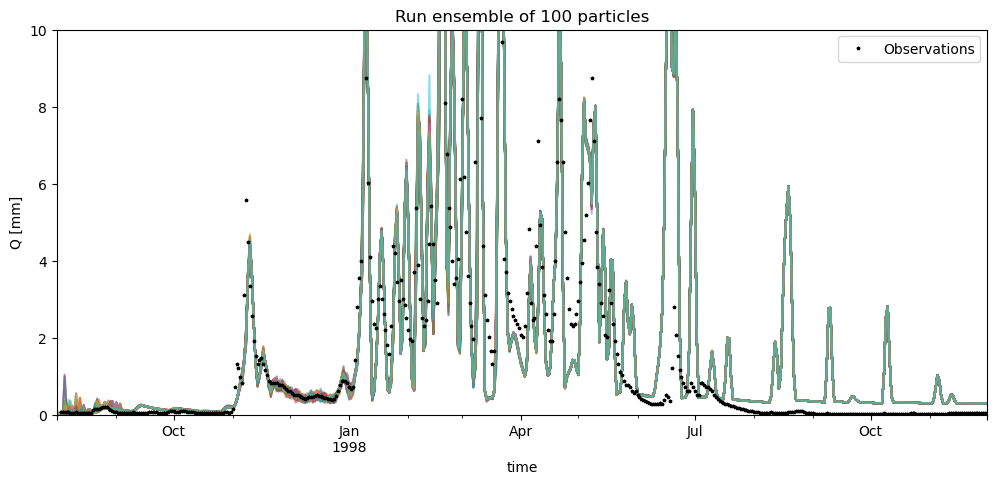

In [34]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False)
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-12-01')))
ax.set_ylim((0,10))

In [35]:
# 0.005 - good under 

In [36]:
figure_path = path / "Figures"
fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png")

Can calculate the mean of 50 particles as a reference

In [37]:
mean_ensemble = df_ensemble.T.mean()
# NSE_mean_ens = calc_NSE(df_Q.loc[Q_obs_t_lst,"Q"],mean_ensemble.values)

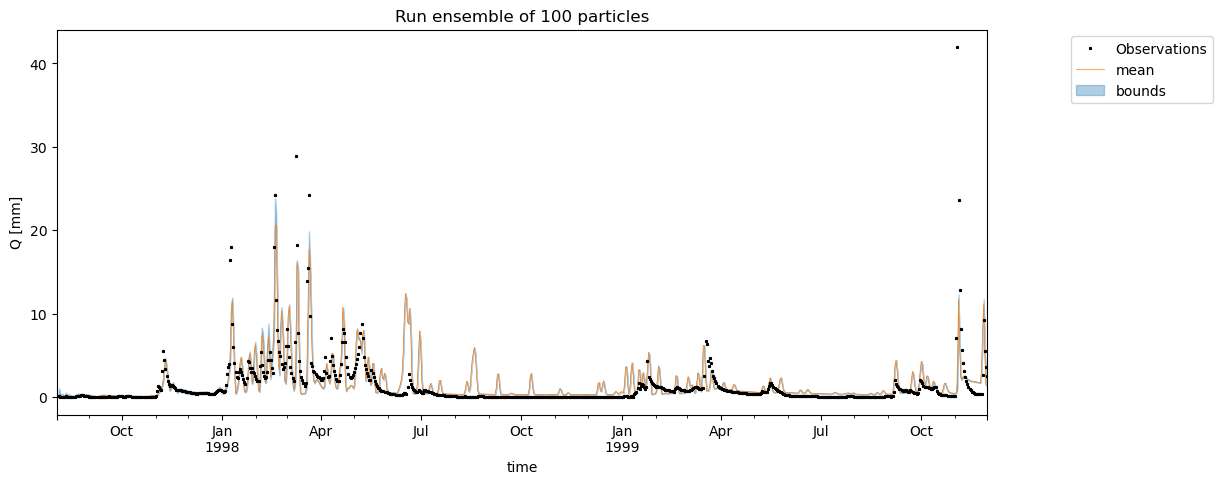

In [38]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
# ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-06-01')))
figure_path = path / "Figures"
fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

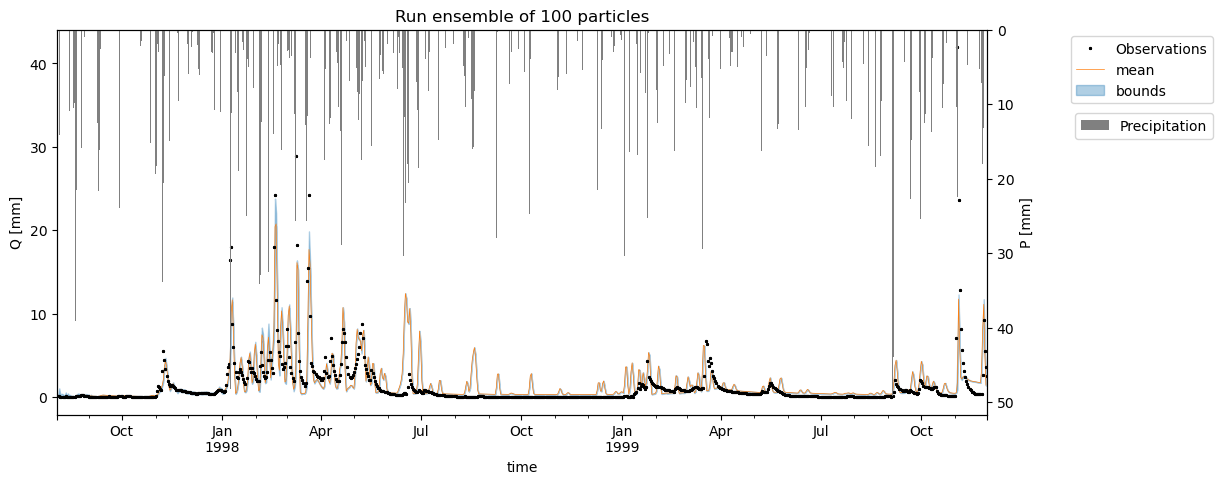

In [39]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
ax_pr.bar(df_ensemble.index,ds['pr'].values[:n_timesteps],zorder=-15,label="Precipitation",color="grey")
ax_pr.legend(bbox_to_anchor=(1.25,0.8))

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");

figure_path = path / "Figures"
fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_bounds_P_{current_time}.png",bbox_inches="tight",dpi=400);

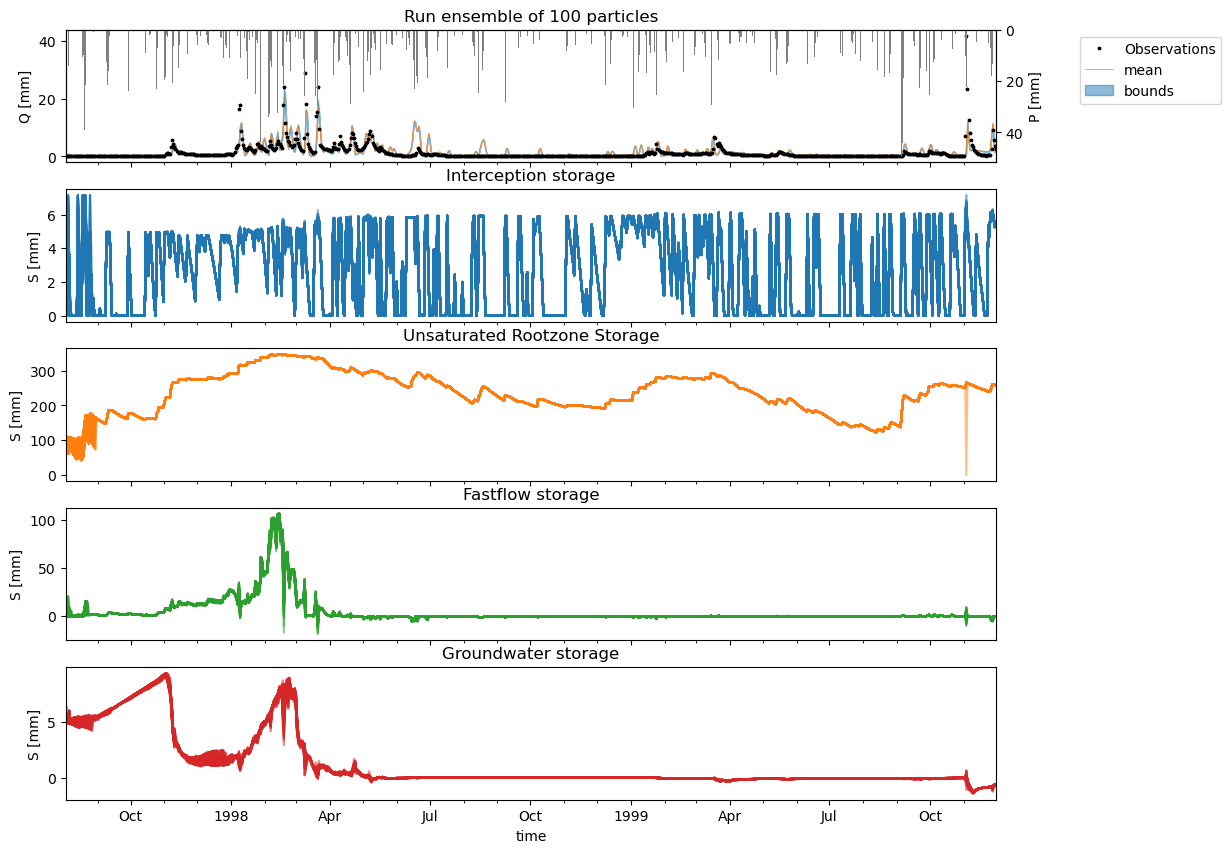

In [40]:
n=5
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
ax_pr.bar(df_ensemble.index,ds['pr'].values[:n_timesteps],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");

for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        storage_terms_ds.isel(storage=i,EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)

# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
figure_path = path / "Figures"
fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

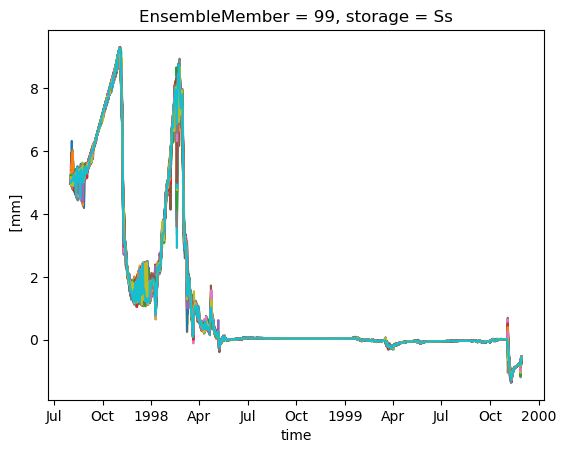

In [41]:
fig, ax = plt.subplots(1,1)
for i in range(n_particles):
    storage_terms_ds.sel(storage="Ss").isel(EnsembleMember=i).plot(ax=ax)

Text(0.5, 1.0, 'parameter=Tlag for 100 Ensemble Members')

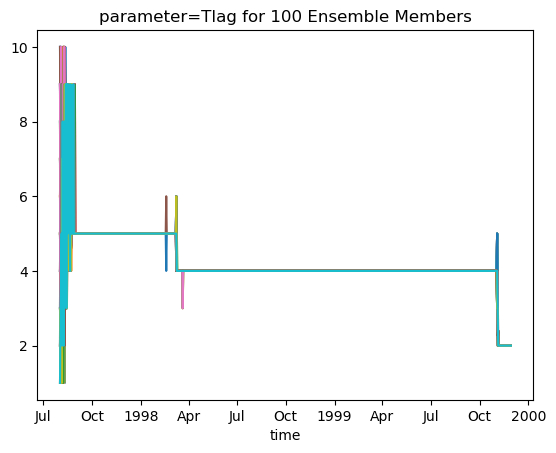

In [42]:
fig, ax = plt.subplots(1,1)

parameter="Tlag"
for i in range(n_particles):
    parameter_terms_ds.sel(parameter=parameter).isel(EnsembleMember=i).plot(ax=ax)
ax.set_title(f'parameter={parameter} for {n_particles} Ensemble Members')

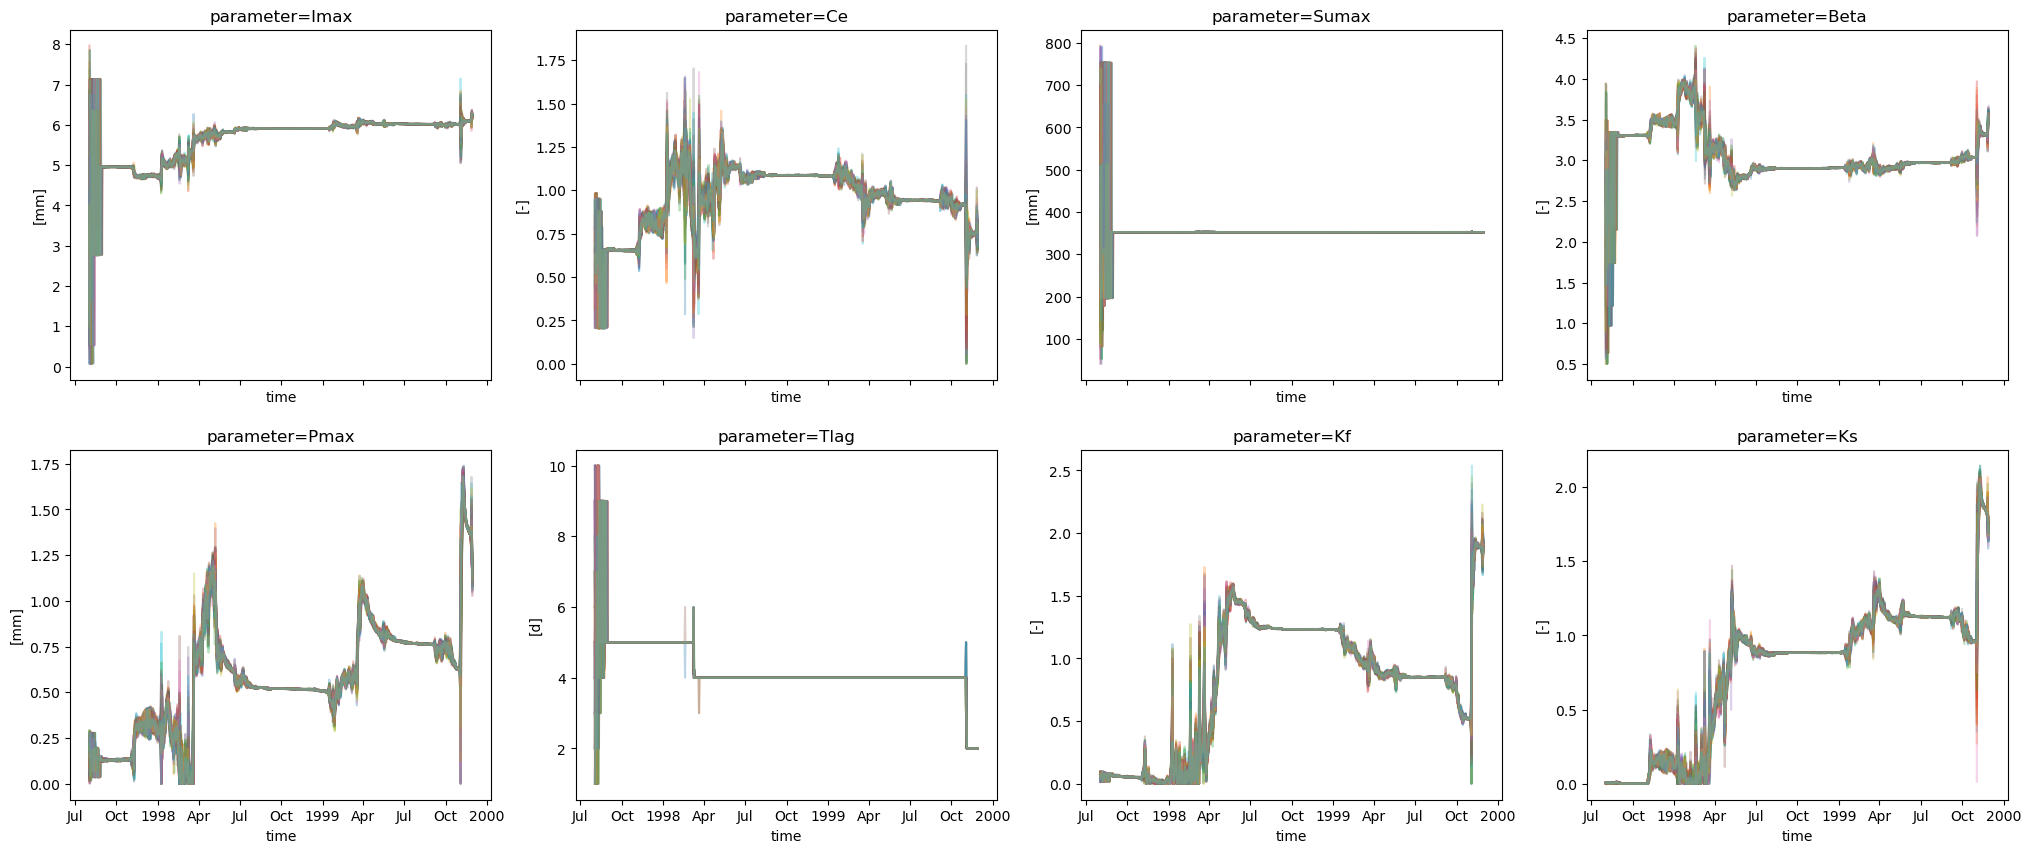

In [43]:
fig, axs = plt.subplots(2,4,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    for i in range(n_particles):
        parameter_terms_ds.sel(parameter=parameter).isel(EnsembleMember=i).plot(ax=ax,alpha=0.3)
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[parameter]}]')
figure_path = path / "Figures"
fig.savefig(figure_path /  f"ensemble_run_for__{n_particles}_particles_parameters_{current_time}.png",bbox_inches="tight",dpi=400)